<a href="https://colab.research.google.com/github/igsxf22/aerial_cloud_classification/blob/main/Aerial_Clouds_Clear_Classification_Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aerial Clouds Clear Classification Experiment
> https://github.com/igsxf22/aerial_cloud_classification


**GOAL**: In one afternoon, create a tiny binary clouds/clear classifier from open source datasets...
* using only publicly available open-source datasets
* without lableing any data
* ***generalized enough to work on variety of imagery***
<br><br>

Scenario for use is for analytics on aerial, nadir or relatively steep from variety of imagery sources
 - Outside that scenario, main limitation is that it'll be inconsistent on clear frames with forward, level cameras that capture cloudy horizons

`generalization test on youtube drone video - video *not* part of the dataset`
![GIF example](https://github.com/igsxf22/aerial_cloud_classification/raw/main/cloud_class_test_640.gif)
<br>`source: https://www.youtube.com/watch?v=1DOc8aZDtGU`

## Outline
1. Download, extract datasets (RESISC45 and GCD)
    - RES45 is parquets, so we'll unpack those with pandas
    - GCD is zipped jpegs

2. Reclassify the datasets into two sets: "clouds" and "clear"
    - RES45 has 45 classes
        - 44 land --> "clear"
        - 1 cloud --> "cloud"
    - GCD has 7 classes
        - 6 clouds --> "cloud
        - 1 clear sky --> "clear"
3. Review totals and decide on sample sizes and split into train, val, test sets
4. Standardize arrays to 256x256x3 and copy images into ultralytics classification path structure
5. Choose your hyperparameters and train with ultralytics CLI
    - On yolo11n-cls with larger batch sizes, expect 50 - 100 epochs



# Setup

In [1]:
# Installing ultralytics will get all libs required
!pip install -q ultralytics

# Get RESISC45 data from HuggingFace
!git clone https://huggingface.co/datasets/tanganke/resisc45

# Download the GCD data from GoogleDrive
# GCD_GoogleDrive_url = "https://drive.google.com/file/d/1dsgoEQLqR3YrOMBC_hOsVEUQC7HuV2fN/view?usp=sharing"
# Source: https://github.com/shuangliutjnu/TJNU-Ground-based-Cloud-Dataset
!gdown -q --id 1dsgoEQLqR3YrOMBC_hOsVEUQC7HuV2fN -O /content/GCD.zip
!unzip -q /content/GCD.zip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 976.9/976.9 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.2 MB/s eta 0:00:00
Cloning into 'resisc45'...
remote: Enumerating objects: 33, done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-re

In [2]:
# Import/define required items
from pathlib import Path
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import random
import pandas as pd
import pyarrow.parquet as pq
from sklearn.model_selection import train_test_split
import shutil

def bgr_array_from_bytes(im_bytes):
    array = np.frombuffer(im_bytes, np.uint8)
    im_array = cv2.imdecode(array, cv2.IMREAD_COLOR)
    return im_array

In [3]:
# Build our dirs for the merged dataset
merged = Path("/content/merged")
merged.mkdir(parents=True, exist_ok=True)

splits = "train", "test", "val"
classes = "clouds", "clear"

for split in splits:
    for cls in classes:
        dst = merged / split / cls
        dst.mkdir(parents=True, exist_ok=True)

# Prepare the RESISC45 Data


RESISC45 dataset is a dataset for Remote Sensing Image Scene Classification (RESISC). It contains 31,500 RGB images of size 256×256 divided into 45 scene classes, each class containing 700 images. Among its notable features, RESISC45 contains varying spatial resolution ranging from 20cm to more than 30m/px.

Links:
- https://github.com/tensorflow/datasets/blob/master/docs/catalog/resisc45.md
- https://paperswithcode.com/dataset/resisc45

![](https://production-media.paperswithcode.com/datasets/resisc.png)<br>



In [4]:
# Unpack RES45 data and reclassify by clouds/no clouds
RES45_CLOUD_LABEL = 9

r45 = Path("/content/resisc45")

train_table_path = Path("/content/r45_train.parquet")
test_table_path = Path("/content/r45_test.parquet")

# Get ims from parquets the long way for learning; read parq files into pd df's
_table = pq.read_table(r45 / "data" / "train-00000-of-00001.parquet")
pq.write_table(_table, train_table_path, compression=None)
train_df = pd.read_parquet(train_table_path)

_table = pq.read_table(r45 / "data" / "test-00000-of-00001.parquet")
pq.write_table(_table, test_table_path, compression=None)
test_df = pd.read_parquet(test_table_path)

# # Uncomment below to see more info on the dataframes
# print("\nRes45 Train dataframe")
# print(train_df.info())
# print(train_df.head(n=5))

# print("\nRes45 Test dataframe")
# print(test_df.info())
# print(test_df.head(n=5))

This should be a cloud image:


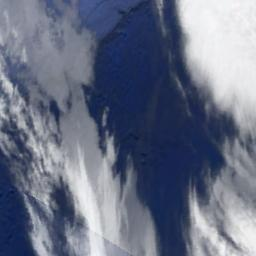

This should be a cloud image:


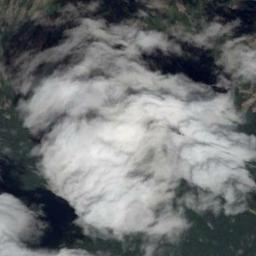

This should be a cloud image:


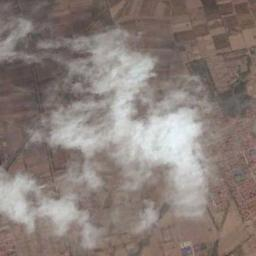

This should be a cloud image:


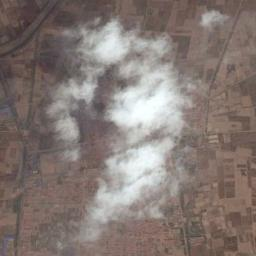

This should be a clear image:


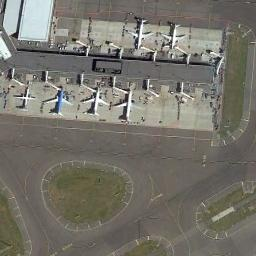

This should be a clear image:


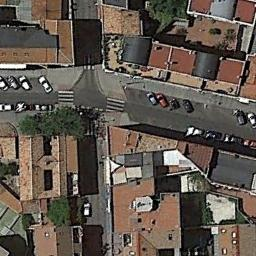

This should be a clear image:


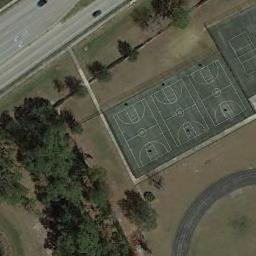

This should be a clear image:


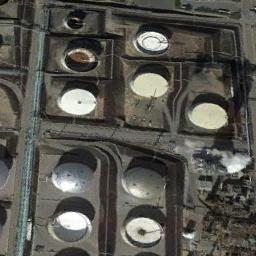

This should be a cloud imag:e


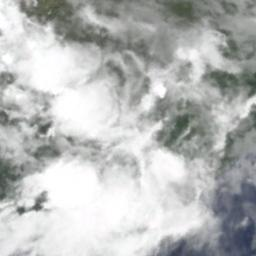

This should be a cloud imag:e


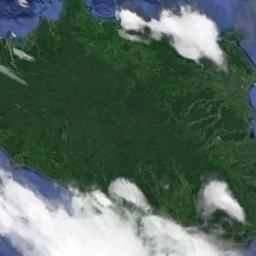

This should be a clear image:


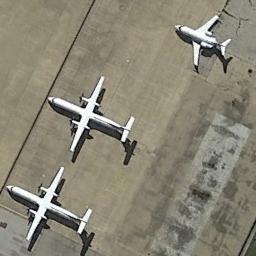

This should be a clear image:


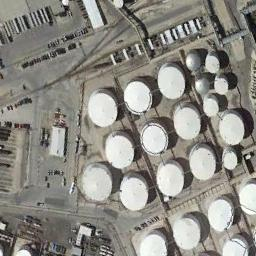

In [5]:
# Split train and test data by label == cloud or label != cloud
train_clouds = [i for i in list(zip(train_df["image"], train_df["label"])) if i[1] == RES45_CLOUD_LABEL]
train_clear = [i for i in list(zip(train_df["image"], train_df["label"])) if i[1] != RES45_CLOUD_LABEL]

test_clouds = [i for i in list(zip(test_df["image"], test_df["label"])) if i[1] == RES45_CLOUD_LABEL]
test_clear = [i for i in list(zip(test_df["image"], test_df["label"])) if i[1] != RES45_CLOUD_LABEL]

# Look at a few ims and check to make sure we split it correctly
# i = [im_dict, im_label]
for i in train_clouds[::100]:
    print("This should be a cloud image:")
    cv2_imshow(bgr_array_from_bytes(i[0]["bytes"]))

for i in train_clear[::5000]:
    print("This should be a clear image:")
    cv2_imshow(bgr_array_from_bytes(i[0]["bytes"]))

for i in test_clouds[::100]:
    print("This should be a cloud imag:e")
    cv2_imshow(bgr_array_from_bytes(i[0]["bytes"]))

for i in test_clear[::5000]:
    print("This should be a clear image:")
    cv2_imshow(bgr_array_from_bytes(i[0]["bytes"]))

In [6]:
# Lets write to our merged dataset structure
for i, (im_dict, label) in enumerate(train_clouds):
    write_path = merged / "train" / "clouds" / f"train_clouds_r45_{i}.jpg"
    cv2.imwrite(write_path, bgr_array_from_bytes(im_dict["bytes"]))

for i, (im_dict, label) in enumerate(train_clear):
    write_path = merged / "train" / "clear" / f"train_clear_r45_{i}.jpg"
    cv2.imwrite(write_path, bgr_array_from_bytes(im_dict["bytes"]))

for i, (im_dict, label) in enumerate(test_clouds):
    write_path = merged / "test" / "clouds" / f"test_clouds_r45_{i}.jpg"
    cv2.imwrite(write_path, bgr_array_from_bytes(im_dict["bytes"]))

for i, (im_dict, label) in enumerate(test_clear):
    write_path = merged / "test" / "clear" / f"test_clear_r45_{i}.jpg"
    cv2.imwrite(write_path, bgr_array_from_bytes(im_dict["bytes"]))

In [7]:
# Check the totals and see if everything got sorted
print("Train data (all classes) size:", len(train_df))
print("Test data (all_classes) size:", len(test_df))

print("\nReclassified and saved arrays:")
print("Train clouds:", len(list((merged / "train" / "clouds").iterdir())))
print("Train clear:", len(list((merged / "train" / "clear").iterdir())))
print("Test clouds:", len(list((merged / "test" / "clouds").iterdir())))
print("Test clear:", len(list((merged / "test" / "clear").iterdir())))

Train data (all classes) size: 18900
Test data (all_classes) size: 6300

Reclassified and saved arrays:
Train clouds: 392
Train clear: 18508
Test clouds: 159
Test clear: 6141


# Prepare the Ground-Based Clouds Data
**Source Dataset**: https://github.com/shuangliutjnu/TJNU-Ground-based-Cloud-Dataset

As you can see from the above dataset, cloudy images vs clear images is 550 out of 18900 in Res45, so we need more cloudy images.

As you'd expect, there's not a ton of cloudy aerial imagery, it usually defeats the purpose of studying the earth.

There is however this **Ground-based** cloud classification dataset, with 6 classes or clouds and 1 for clear sky.

`Ground-based Cloud Data Example`:
![GCD Data Example](https://github.com/shuangliutjnu/TJNU-Ground-based-Cloud-Dataset/blob/main/image.jpg?raw=true)

While an air-to-ground cloud dataset would be ideal, since the problem is usually clouds obscuring the entire field of view of the camera, a ground-to-sky dataset of clouds where clouds fill most of the frame, this may be enough for a small binary classification model.



In [8]:
# Check out the GCD data
gcd = Path("/content/GCD")

gcd_counts = {"train": 0, "test": 0, "train_clouds": 0,
              "train_clear": 0, "test_clouds": 0, "test_clear": 0}

for i in gcd.iterdir():
    print(i.name)

    for j in i.iterdir():
        print("\t", j.name, len(list(j.iterdir())))

        if i.name == "train":
            gcd_counts["train"] += len(list(j.iterdir()))

        elif i.name == "test":
            gcd_counts["test"] += len(list(j.iterdir()))

        if i.name == "train" and j.name == "4_clearsky":
            gcd_counts["train_clear"] += len(list(j.iterdir()))

        if i.name == "train" and j.name != "4_clearsky":
            gcd_counts["train_clouds"] += len(list(j.iterdir()))

        if i.name == "test" and j.name == "4_clearsky":
            gcd_counts["test_clear"] += len(list(j.iterdir()))

        if i.name == "test" and j.name != "4_clearsky":
            gcd_counts["test_clouds"] += len(list(j.iterdir()))

print("\nGCD path totals:")
print("Total train:", gcd_counts["train"], "Total test:", gcd_counts["test"])
print("Train clouds:", gcd_counts["train_clouds"], "Train clear:", gcd_counts["train_clear"])
print("Test clouds:", gcd_counts["test_clouds"], "Test clear:", gcd_counts["test_clear"])

test
	 4_clearsky 1589
	 3_cirrus 753
	 7_mixed 607
	 2_altocumulus 750
	 5_stratocumulus 1790
	 6_cumulonimbus 2761
	 1_cumulus 750
train
	 4_clearsky 2150
	 3_cirrus 1153
	 7_mixed 348
	 2_altocumulus 725
	 5_stratocumulus 1846
	 6_cumulonimbus 3003
	 1_cumulus 775

GCD path totals:
Total train: 10000 Total test: 9000
Train clouds: 7850 Train clear: 2150
Test clouds: 7411 Test clear: 1589


In [9]:
# GCD Data is already saved as jpegs so we won't have to unpack parquets with pandas
# So lets start reclassifying to clouds / clear

sorted_counts = {"train_clouds": 0, "train_clear": 0,
                 "test_clouds": 0, "test_clear": 0}

# Split train by clouds / clear, save to merged dataset
for folder in Path(gcd / 'train').iterdir():
    for i, img_path in enumerate(list(folder.iterdir())):

        if folder.name == '4_clearsky':
            write_path = merged / "train" / "clear" / f"train_clear_gcd_{img_path.name}"
            array = cv2.imread(img_path)
            cv2.imwrite(write_path, cv2.resize(array, (256, 256)))
            sorted_counts["train_clear"] += 1

        else:
            write_path = merged / "train" / "clouds" / f"train_clouds_gcd_{img_path.name}"
            array = cv2.imread(img_path)
            cv2.imwrite(write_path, cv2.resize(array, (256, 256)))
            sorted_counts["train_clouds"] += 1

# Same for test
for folder in Path(gcd / 'test').iterdir():
    for i, img_path in enumerate(list(folder.iterdir())):

        if folder.name == '4_clearsky':
            write_path = merged / "test" / "clear" / f"test_clear_gcd_{img_path.name}"
            array = cv2.imread(img_path)
            cv2.imwrite(write_path, cv2.resize(array, (256, 256)))
            sorted_counts["test_clear"] += 1

        else:
            write_path = merged / "test" / "clouds" / f"test_clouds_gcd_{img_path.name}"
            array = cv2.imread(img_path)
            cv2.imwrite(write_path, cv2.resize(array, (256, 256)))
            sorted_counts["test_clouds"] += 1

In [10]:
# Dataset totals so far
total_merged_dataset = len(list((merged / "train" / "clouds").iterdir())) + len(list((merged / "train" / "clear").iterdir()))
print("\nTotal merged dataset:", total_merged_dataset)

for i in merged.iterdir():
    print("\t", i.name)
    for j in i.iterdir():
        print("\t\t", j.name, len(list(j.iterdir())))



Total merged dataset: 28900
	 test
		 clear 7730
		 clouds 7570
	 train
		 clear 20658
		 clouds 8242
	 val
		 clear 0
		 clouds 0


# Sample and Split Data for Training

In [11]:
from operator import le
# Create a sampled dataset
# We probably don't need all these images for a prototype, lets just go with 25% of it
# And we need to borrow images from the train set to make a val set

# We'll collect paths and then write into a yolo style path structure for classification training

# clear existing to resample
!rm -rf /content/sampled

# Create new data set root
sampled = Path("/content/sampled")

# Copy our merged tree paths
for i in merged.iterdir():
    for j in i.iterdir():
        copy_path = sampled / i.name / j.name
        copy_path.mkdir(parents=True, exist_ok=True)
        print(copy_path)

sample_sizes = {"train_clouds": 3000, "train_clear": 4000, "test_clouds": 500, "test_clear": 600}

# We'll fill this data dict with sampled splits
ds = {"train": {"clouds": [], "clear": []},
     "val": {"clouds": [], "clear": []},
     "test": {"clouds": [], "clear": []}}

sampled_train_clouds = random.sample(list((merged / "train" / "clouds").iterdir()),
                                     sample_sizes["train_clouds"])

ds["train"]["clouds"], ds["val"]["clouds"] = train_test_split(sampled_train_clouds,
                                                              test_size=0.15,
                                                              random_state=10)

sampled_train_clear = random.sample(list((merged / "train" / "clear").iterdir()),
                                    sample_sizes["train_clear"])

ds["train"]["clear"], ds["val"]["clear"] = train_test_split(sampled_train_clear,
                                                            test_size=0.15,
                                                            random_state=10)

sampled_test_clouds = random.sample(list((merged / "test" / "clouds").iterdir()),
                                    sample_sizes["test_clouds"])

sampled_test_clear = random.sample(list((merged / "test" / "clear").iterdir()),
                                   sample_sizes["test_clear"])

ds["test"]["clouds"] = sampled_test_clouds
ds["test"]["clear"] = sampled_test_clear

print("\nTrain clouds:", len(ds["train"]["clouds"]), "Val clouds:", len(ds["val"]["clouds"]))
print("\nTrain clear:", len(ds["train"]["clear"]), "Val clear:", len(ds["val"]["clear"]))
print("\nTest clouds:", len(ds["test"]["clouds"]), "Test clear:", len(ds["test"]["clear"]))

for split, split_dict in ds.items():
    for cls, cls_list in split_dict.items():
        _copy_path = sampled / split / cls
        for i in cls_list:
            shutil.copy(i, _copy_path)


/content/sampled/test/clear
/content/sampled/test/clouds
/content/sampled/train/clear
/content/sampled/train/clouds
/content/sampled/val/clear
/content/sampled/val/clouds

Train clouds: 2550 Val clouds: 450

Train clear: 3400 Val clear: 600

Test clouds: 500 Test clear: 600


# Train with Ultralytics YOLOv11
Hyperparamters here are geared towards speed for the demo, change as needed

In [12]:
# Set your hyperparameters and train
!yolo classify train data=/content/sampled model=yolo11n-cls.pt epochs=128 imgsz=256 batch=256 patience=32 cache=True

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
100% 5.52M/5.52M [00:00<00:00, 372MB/s]
Ultralytics 8.3.99 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: task=classify, mode=train, model=yolo11n-cls.pt, data=/content/sampled, epochs=128, time=None, patience=32, batch=256, imgsz=256, save=True, save_period=-1, cache=True, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybri

# Create a random sampled test mosaic

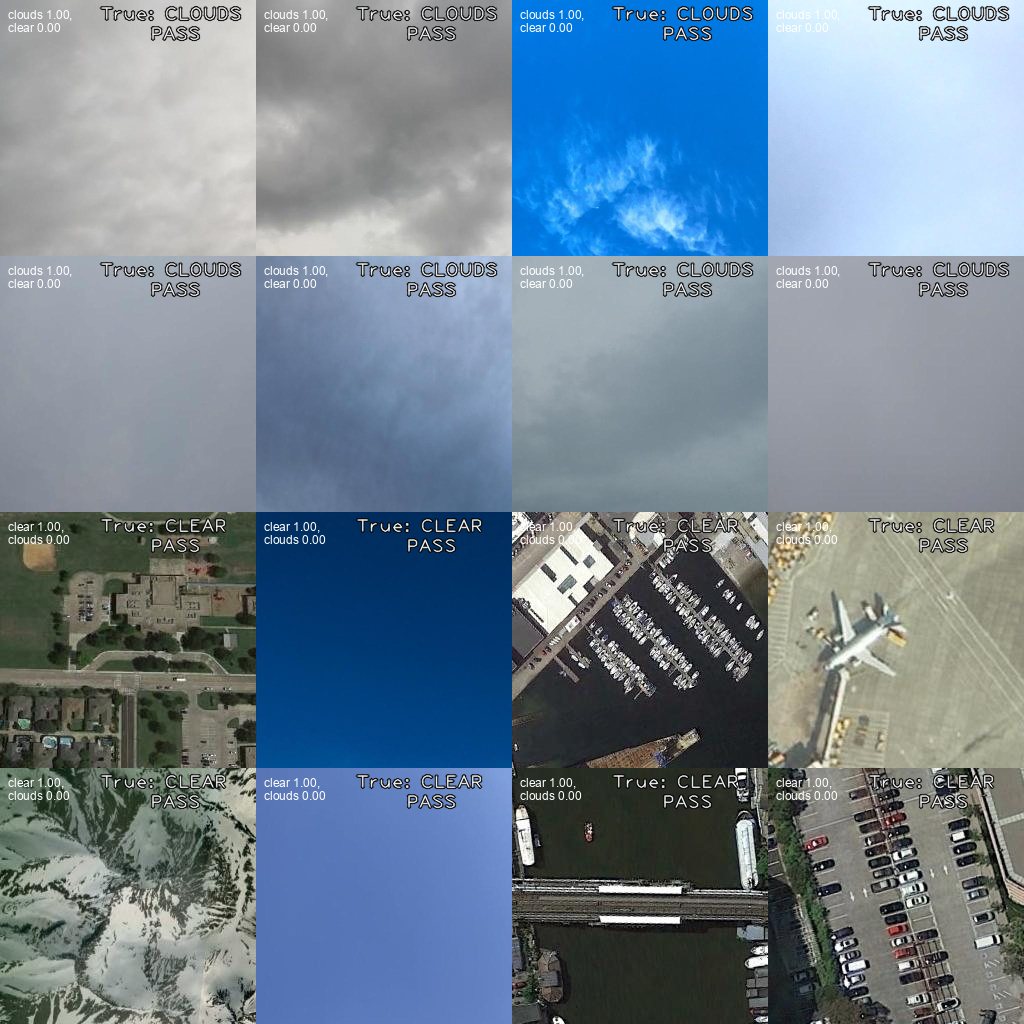

True

In [13]:
# Create a visual test mosaic with 8x8 image grid
# Repeat to try a new sample from the merged data test images
from ultralytics import YOLO
model = YOLO("/content/runs/classify/train/weights/best.pt")

test_clouds_path = Path("/content/merged/test/clouds")
test_clear_path = Path("/content/merged/test/clear")

random_samples_clouds = random.sample(list(test_clouds_path.iterdir()), 8)
random_samples_clear = random.sample(list(test_clear_path.iterdir()), 8)

cloud_ims = [cv2.imread(str(x)) for x in random_samples_clouds]
clear_ims = [cv2.imread(str(x)) for x in random_samples_clear]

mosaic_ims = []

for i, im in enumerate(cloud_ims):
    results = model(im, verbose=False)
    for result in results:
        plot = result.plot().copy()
        cv2.putText(plot, "True: CLOUDS", (100, 20), 1, 1.25, (0,0,0), 2, cv2.LINE_AA)
        cv2.putText(plot, "True: CLOUDS", (100, 20), 1, 1.25, (255,255,255), 1, cv2.LINE_AA)

        if  model.names[result.probs.top1] == "clouds":
            cv2.putText(plot, "PASS", (150, 40), 1, 1.25, (0,0,0), 2, cv2.LINE_AA)
            cv2.putText(plot, "PASS", (150, 40), 1, 1.25, (255,255,255), 1, cv2.LINE_AA)
        else:
            cv2.putText(plot, "FAIL", (150, 40), 1, 1.25, (0,0,0), 2, cv2.LINE_AA)
            cv2.putText(plot, "FAIL", (150, 40), 1, 1.25, (255,255,255), 1, cv2.LINE_AA)

        mosaic_ims.append(plot)

for i, im in enumerate(clear_ims):
    results = model(im, verbose=False)
    for result in results:
        plot = result.plot().copy()
        cv2.putText(plot, "True: CLEAR", (100, 20), 1, 1.25, (0,0,0), 2, cv2.LINE_AA)
        cv2.putText(plot, "True: CLEAR", (100, 20), 1, 1.25, (255,255,255), 1, cv2.LINE_AA)
        if model.names[result.probs.top1] == "clear":
            cv2.putText(plot, "PASS", (150, 40), 1, 1.25, (0,0,0), 2, cv2.LINE_AA)
            cv2.putText(plot, "PASS", (150, 40), 1, 1.25, (255,255,255), 1, cv2.LINE_AA)
        else:
            cv2.putText(plot, "FAIL", (150, 40), 1, 1.25, (0,0,0), 2, cv2.LINE_AA)
            cv2.putText(plot, "FAIL", (150, 40), 1, 1.25, (255,255,255), 1, cv2.LINE_AA)

        mosaic_ims.append(plot)

# Create 4 x 4 mosaic
mosaic = np.zeros((1024, 1024, 3), dtype=np.uint8)
for i in range(4):
    for j in range(4):
        mosaic[i*256:(i+1)*256, j*256:(j+1)*256] = mosaic_ims[i*4+j]
cv2_imshow(mosaic)
cv2.imwrite("/content/mosaic.jpg", mosaic)